In [ ]:
!pip install bs4
!pip install nltk
!pip install wordcloud
!pip install xgboost
!pip install emoji --upgrade

     |████████████████████████████████| 133kB 7.6MB/s 


# Import modules

In [ ]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup

import emoji
import string
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from statistics import mean
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from wordcloud import WordCloud
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, accuracy_score
import matplotlib as mpl
import seaborn as sns
from gensim.models import word2vec

# Custom settings to view all column names and their data in the output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

#### WARNINGs
import warnings
warnings.filterwarnings("ignore")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



In [ ]:
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
#importing stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words_list=stopwords.words('english')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#mounting in colab
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#change main directory to drive
root_dir = "/content/gdrive/My Drive/TweetAnalysis"
%cd "/content/gdrive/MyDrive/TweetAnalysis"

/content/gdrive/MyDrive/TweetAnalysis


## 1.Reading Generic Tweets
The primary step for data analysis is to read the input data. To this aim, the the given csv files are read and tranferred to a data frame.

In [ ]:
#from google.colab import files
data = pd.read_csv('sentiment_analysis.csv', sep  = "," )
data.head(5)

ID  \
0  7.680980e+17   
1  7.680980e+17   
2  7.680980e+17   
3  7.680980e+17   
4  7.680980e+17   

                                                                                                                                           text  \
0  Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday https://t.co/antImqAo4Y https://t.co/ejnA78Sks0                             
1  RT @MianUsmanJaved: Congratulations Pakistan on becoming #No1TestTeam in the world against all odds! #JI_PakZindabadRallies https://t.co/1o…   
2  RT @PEPalerts: This September, @YESmag is taking you to Maine Mendoza’s surprise thanksgiving party she threw for her fans! https://t.co/oX…   
3  RT @david_gaibis: Newly painted walls, thanks a million to our custodial painters this summer.  Great job ladies!!!#EC_proud https://t.co/…    
4  RT @CedricFeschotte: Excited to announce: as of July 2017 Feschotte lab will be relocating to @Cornell MBG https://t.co/dd0FG7BRx3             

   label  
0  1      
1  1      
2  1      
3  1      
4  1

## 1.1 Data Cleaning and Preparation

The first step is to clean the data and remove any noise and meaningless characters. Through the steps given below the data is cleaned and ready for further analysis. Each step is specified with a number which you can find its relevent code in the body of the cleaning function below. Steps of the data cleaning are explained in the comments for each step. NLTK module is used to delete stopwords and lematize words to their roots and omit unnecessary words thay don't have effect on the sentiment of the tweet. Some of the steps used that may need explanations are these :

**Lematizistion** : Stemming is the process of reducing words to their core root. As there can be understemming or overstemming of words, this process can affect the model.Stemming just removes or stems the last few characters of a word, often leading to incorrect meanings and spelling. So we will use  **Lemmatization**. It considers the context and converts the word to its meaningful base form

**Removing Stop Words**: A stop word is a commonly used word. Removing stopwords will help us build more simple datasets that are computationally more effective. We use ready package from nltk to remove stop words.

**Deemojize** : As emojis can give us relevent inofrmation about the sentimentm we will demojies the text with the help of the emoji package

In [ ]:
tokenizer = WordPunctTokenizer()

def text_cleaning(text_column):
    
    # replacing HTML character codes with an ASCII equivalent 
    text_column = BeautifulSoup(text_column, 'lxml')
    replaced_with_ASCII = text_column.get_text()

    # removing URLs 
    url_cleaned = re.sub(r'|http\S+', "", replaced_with_ASCII)
    
    # In this section, we will also remove hashtags, mentions, emojies and websites. 
    # websites:
    websites_removed = re.sub(r'www.[^ ]+', '', url_cleaned)
    # hashtags:
    hashtag_removed = re.sub(r"(?:\#+)",'', websites_removed)
    # mentions:
    mention_removed = re.sub(r'(?:@[\w_]+)', '', hashtag_removed)

    #remove RT
    rt_removed = re.sub("RT ", " ", mention_removed)

    # As emojis can give us relevent inofrmation about the sentimentm we will demojies the text with the help of the package:
    demojized_text=emoji.demojize(rt_removed,delimiters=("", " "))
    
    # lowercase handling
    lowercase_text = demojized_text.lower()
    
    # removing HTML tags and attributes 
    tags_removed = re.sub("[^a-zA-Z]", " ", lowercase_text)

    
    
    # During the aforementioned processes, extra whitespaces have been produced, which we have to remove. 
    clean_words = tokenizer.tokenize(tags_removed)
    
   
    # removing stop words
    # In this section, we will use the stop words from nltk module 
    final_words = [word for word in clean_words
                  if word not in stop_words_list]
  

    #lematization
    lemmatizer=WordNetLemmatizer()
    lematized_word = [lemmatizer.lemmatize(word) for word in final_words] 

    #removing single letter as they don't convey any meaning
    lematized_word = [word for word in lematized_word if (len(word)>1)]
    
    #Since we used tokenizer,we have to rejoin the words to create the tweet.
    final_text = (" ".join( lematized_word)).strip()  

    return (final_text)

In [ ]:
#clean the whole text and save it in tweets column

data['tweets'] = data['text'].apply(lambda x: text_cleaning(x))

As we don't want to run the cleanig part of code every time we open the notebook, we save the cleaned data in the drive

In [ ]:
#download clean file on local computer
from google.colab import files
data.to_csv('data_cleaned.csv' , index = False) 
files.download('data_cleaned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
##I saved cleaned data in order not to run it every time and here I will read it
data=pd.read_csv('data_cleaned.csv')

#Dropping Nulls
#dropping the nulls before vectorizing as some tweets do not convey meaningful information after lematization and they convert to None

data = data.dropna(subset=['tweets'])

In [ ]:
#check cleaned tweets
data.head(5)

ID  \
0  7.680980e+17   
1  7.680980e+17   
2  7.680980e+17   
3  7.680980e+17   
4  7.680980e+17   

                                                                                                                                           text  \
0  Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday https://t.co/antImqAo4Y https://t.co/ejnA78Sks0                             
1  RT @MianUsmanJaved: Congratulations Pakistan on becoming #No1TestTeam in the world against all odds! #JI_PakZindabadRallies https://t.co/1o…   
2  RT @PEPalerts: This September, @YESmag is taking you to Maine Mendoza’s surprise thanksgiving party she threw for her fans! https://t.co/oX…   
3  RT @david_gaibis: Newly painted walls, thanks a million to our custodial painters this summer.  Great job ladies!!!#EC_proud https://t.co/…    
4  RT @CedricFeschotte: Excited to announce: as of July 2017 Feschotte lab will be relocating to @Cornell MBG https://t.co/dd0FG7BRx3             

   label  \
0  1       
1  1       
2  1       
3  1       
4  1       

                                                                               tweets  
0  josh jenkins looking forward tab breeder crown super sunday                         
1  congratulation pakistan becoming testteam world odds ji pakzindabadrallies          
2  september taking maine mendoza surprise thanksgiving party threw fan                
3  newly painted wall thanks million custodial painter summer great job lady ec proud  
4  excited announce july feschotte lab relocating mbg

##1.2 Exploratory Analysis for generic tweets file
In this part we will plot wordcloud. The word cloud give us a btter intution about the distribution of keywords and thier frequency. We plot the wordcloud for both negetive and positive tweets. 


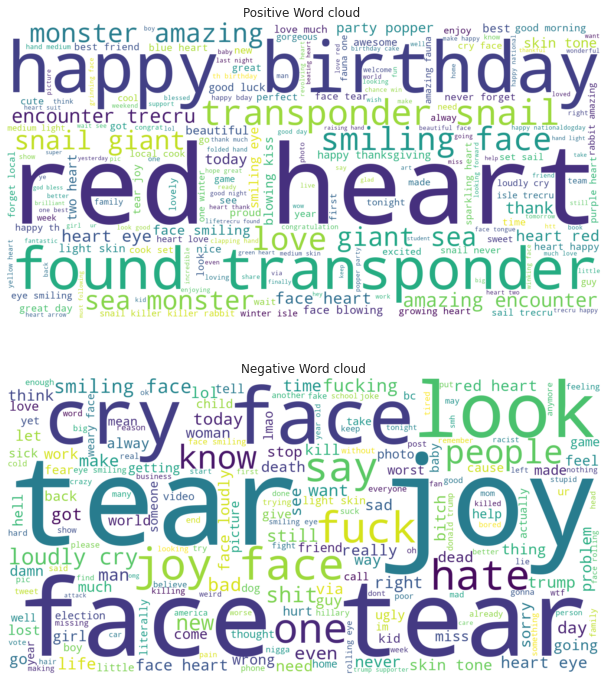

<function matplotlib.pyplot.show>

<Figure size 792x1152 with 0 Axes>

In [ ]:
#Word cloud - Positive Tweets
generic_tweets = data['tweets'][data['label']==1]
total_txt = []
for tweet in generic_tweets:
    total_txt.append(tweet)
    
total_txt = pd.Series(total_txt).str.cat(sep=' ')


pos_wordcloud = WordCloud(width=1600, height=800,max_font_size=400,background_color ='white').generate(total_txt)

fig, ax = plt.subplots(2, 1, figsize = (15,12))
ax[0].set_title('Positive Word cloud ')
ax[0].imshow(pos_wordcloud, interpolation="bilinear")
ax[0].axis("off")

#Word cloud - Negetive Tweets
generic_tweets = data['tweets'][data['label'] == 0]
total_txt = []
for tweet in generic_tweets:
    total_txt.append(tweet)
total_txt = pd.Series(total_txt).str.cat(sep=' ')

neg_wordcloud = WordCloud(width=1600, height=800,max_font_size=400,background_color ='white').generate(total_txt)


ax[1].imshow(neg_wordcloud, interpolation="bilinear")
ax[1].axis("off")
ax[1].set_title('Negative Word cloud')
plt.show()
plt.savefig('Word Clouds.png')
plt.show

**Discussion:**
As we see, there are words that are totally representive of positive and negetive sentiments in both clouds.Especially as we don't delete emojies and substitude them with words, wee see that they also apear in the wordcloud like cry face, or smiling face, which is obviously relevent to negetive and positive emotions in consequense.  
For example:
**Positve emotion words**: read heart, smiling face, love, nice
**Negative emotion words**: tear, cry face, hate, hate





**Most Frequent Word Sentiment Analysis**

In [ ]:
tweet_vectorizer = CountVectorizer()
#fitting to all tweets (getting the feature names)
tweet_vectorizer.fit(data['tweets'])
#transforming to positive tweets -> assigning each positive tweet the number of repetition of each feature name 
positive_matrix = tweet_vectorizer.transform(data[data['label']==1].tweets)
#summing the number of repetition of each feature name over the the whole positive tweets
positive_tf=np.sum(positive_matrix,axis=0)
positive = np.squeeze(np.asarray(positive_tf))

#transforming to negative tweets -> assigning each negative tweet the number of repetition of each feature name 
negative_matrix = tweet_vectorizer.transform(data[data['label']==0].tweets)
#summing the number of repetition of each feature name over the the whole negative tweets
negative_tf=np.sum(negative_matrix,axis=0)
negative = np.squeeze(np.asarray(negative_tf))

In [ ]:
term_frequency=pd.DataFrame([negative,positive],columns=tweet_vectorizer.get_feature_names()).transpose() #generating a dataframe to show the term frequency of feature name ove the whole negative and positive tweets

In [ ]:
term_frequency.columns = ['negative', 'positive']
term_frequency['total'] = term_frequency['negative'] + term_frequency['positive']
most_frequent_feature_names_df=term_frequency.sort_values(by='total', ascending=False).iloc[:15]
most_frequent_feature_names_df[:15]

negative  positive  total
heart     6815      58857     65672
love      1383      54778     56161
face      22113     33895     56008
happy     142       51830     51972
great     233       29246     29479
good      1110      27241     28351
day       3269      23521     26790
best      503       25271     25774
birthday  135       25264     25399
red       1853      22968     24821
amazing   32        24656     24688
smiling   3249      16664     19913
one       4385      14086     18471
eye       4189      13646     17835
thank     63        17337     17400

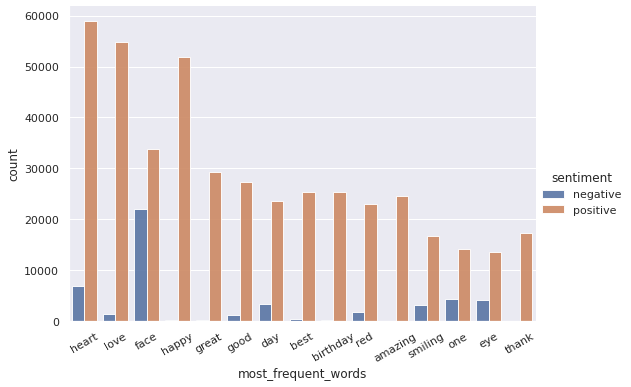

In [ ]:
most_frequent_feature_names_df['most_frequent_words'] = most_frequent_feature_names_df.index
words_data_frame = pd.melt(most_frequent_feature_names_df[['most_frequent_words','negative','positive']], id_vars='most_frequent_words', var_name="sentiment", value_name="count")
sns.set(rc={'figure.figsize':(11,16)})
chart=sns.catplot(x='most_frequent_words', y='count', hue='sentiment', data=words_data_frame, kind='bar', alpha=0.9 , aspect= 1.5)
#chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart.set_xticklabels(rotation=30)

chart.savefig('most frequent.png')

**Discussion** : As we see, words with positive sentiments such as happy, love, heart, best have higher positive counts

##1.3 Modeling Generic Tweets - Feature Extraction
To this end, first we define how we prepare the data to feed the model, this will contain extracting the features from the data. As mentioned in the assignment, we will prepare the TF-IDF and Bag of Words features, and then feed the different models.


In [ ]:
#build X and y for training model based data file
X = data['tweets']
y = data['label']

In [ ]:
#Spliting whole data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=41, test_size=0.35)

Both BoW and TF-IDF are techniques that help us convert text sentences into numeric vectors. The Bag of Words (BoW) model is the simplest form of text representation in numbers. Like the term itself, we can represent a sentence as a bag of words vector (a string of numbers). Bag of Words just creates a set of vectors containing the count of word occurrences in the document, while the TF-IDF model contains information on the more important words and the less important ones as well.Bag of Words vectors are easy to interpret. However, TF-IDF usually performs better in machine learning models.

In [ ]:
#sparse matrix for bag of words
#max_features are added to vetoriztion to limit number of features for models and decrease computation
count_vectorizer = CountVectorizer(max_features = 2000 )
BagofWords_train = count_vectorizer.fit_transform(X_train)
BagofWords_test = count_vectorizer.transform(X_test)


In [ ]:
#sparse matrix for TFIDF
TF_IDF_vectorizer = TfidfVectorizer(max_features = 2000 )
TF_IDF_train = TF_IDF_vectorizer.fit_transform(X_train)
TF_IDF_test = TF_IDF_vectorizer.transform(X_test)

##Feeding Data to different models
In this part we feed data to 7 models, and chooose best models based on f1 score parameters. The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. By putting average= 'macro' the score will be calculated metrics for each label, and find their unweighted meandoes and it does not take label imbalance into account. Indeed a macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally)

## Model 1: Logistic Regression



In [ ]:
#model 1 LogisticRegression
model_LR_BOW = LogisticRegression( C=1 , solver = 'saga')    
model_LR_BOW.fit(BagofWords_train, y_train)
train_predictions = model_LR_BOW.predict(BagofWords_train)
predictions = model_LR_BOW.predict(BagofWords_test)


f1_train_score = f1_score(y_train, train_predictions, average='macro')   
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1_test_score = f1_score(y_test, predictions , average='macro')

LR_BOW=f1_test_score

print ("This model got an accuracy of {}% on the testing set".format(round(accuracy*100,3))) 
print ("This model got a precision of {}% on the testing set".format(round(precision*100,3))) 
print ("This model got a recall of {}% on the testing set".format(round(recall*100,3)))
print ("This model got a f1_score of {}% on the testing set".format(round(f1_test_score*100,3)))
print ("\nThis model got a f1_score of {}% on the training set".format(round(f1_train_score*100,3)))

### Saving the model
 
import joblib
filename = 'model_LR_BOW.sav'
joblib.dump(model_LR_BOW, filename)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


This model got an accuracy of 95.221% on the testing set
This model got a precision of 97.02% on the testing set
This model got a recall of 96.066% on the testing set
This model got a f1_score of 94.406% on the testing set

This model got a f1_score of 94.594% on the training set


['model_LR_BOW.sav']

In [ ]:
#model 1 LogisticRegression

model_LR_TF_IDF = LogisticRegression(solver = 'saga')    
model_LR_TF_IDF.fit(TF_IDF_train, y_train)

predictions = model_LR_TF_IDF.predict(TF_IDF_test)
train_predictions = model_LR_TF_IDF.predict(TF_IDF_train)
    
f1_train_score = f1_score(y_train, train_predictions, average='macro')   
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1_test_score = f1_score(y_test, predictions , average='macro')

LR_TF_IDF = f1_test_score

print ("This model got an accuracy of {}% on the testing set".format(round(accuracy*100,3))) 
print ("This model got a precision of {}% on the testing set".format(round(precision*100,3))) 
print ("This model got a recall of {}% on the testing set".format(round(recall*100,3)))
print ("This model got a f1_score of {}% on the testing set".format(round(f1_test_score*100,3)))
print ("\nThis model got a f1_score of {}% on the training set".format(round(f1_train_score*100,3)))

#saving the model
filename = 'model_LR_TF_IDF.sav'
joblib.dump(model_LR_TF_IDF, filename)


This model got an accuracy of 95.225% on the testing set
This model got a precision of 96.784% on the testing set
This model got a recall of 96.144% on the testing set
This model got a f1_score of 94.558% on the testing set

This model got a f1_score of 94.793% on the training set


['model_LR_TF_IDF.sav']

## Model 2: kNN Classifer 



In [ ]:
#model 2 KNN

%%time
model_KNN_BOW = KNeighborsClassifier()  
model_KNN_BOW.fit(BagofWords_train, y_train)

predictions = model_KNN_BOW.predict(BagofWords_test)
    
train_predictions = model_KNN_BOW.predict(BagofWords_train)
    
f1_train_score = f1_score(y_train, train_predictions, average='macro')   
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1_test_score = f1_score(y_test, predictions , average='macro')

KNN_BOW = f1_test_score

print ("This model got an accuracy of {}% on the testing set".format(round(accuracy*100,3))) 
print ("This model got a precision of {}% on the testing set".format(round(precision*100,3))) 
print ("This model got a recall of {}% on the testing set".format(round(recall*100,3)))
print ("This model got a f1_score of {}% on the testing set".format(round(f1_test_score*100,3)))
print ("\nThis model got a f1_score of {}% on the training set".format(round(f1_train_score*100,3)))

#saving the model
filename = 'model_KNN_BOW.sav'
joblib.dump(model_KNN_BOW, filename)


This model got an accuracy of 91.076% on the testing set
This model got a precision of 95.709% on the testing set
This model got a recall of 90.898% on the testing set
This model got a f1_score of 90.055% on the testing set

This model got a f1_score of 93.035% on the training set
CPU times: user 1h 18min 44s, sys: 32.5 s, total: 1h 19min 16s
Wall time: 1h 19min 32s


In [ ]:
#model 2 KNN

%%time
model_KNN_TF_IDF = KNeighborsClassifier()  
model_KNN_TF_IDF.fit(TF_IDF_train, y_train)

predictions = model_KNN_TF_IDF.predict(TF_IDF_test)
    
train_predictions = model_KNN_TF_IDF.predict(TF_IDF_train)
    
f1_train_score = f1_score(y_train, train_predictions, average='macro')   
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1_test_score = f1_score(y_test, predictions , average='macro')

KNN_TF_IDF = f1_test_score

print ("This model got an accuracy of {}% on the testing set".format(round(accuracy*100,3))) 
print ("This model got a precision of {}% on the testing set".format(round(precision*100,3))) 
print ("This model got a recall of {}% on the testing set".format(round(recall*100,3)))
print ("This model got a f1_score of {}% on the testing set".format(round(f1_test_score*100,3)))
print ("\nThis model got a f1_score of {}% on the training set".format(round(f1_train_score*100,3)))

#saving the model
filename = 'model_KNN_TF_IDF.sav'
joblib.dump(model_KNN_TF_IDF, filename)

This model got an accuracy of 83.382% on the testing set
This model got a precision of 92.549% on the testing set
This model got a recall of 82.069% on the testing set
This model got a f1_score of 81.992% on the testing set

This model got a f1_score of 87.578% on the training set
CPU times: user 1h 2min 11s, sys: 19.2 s, total: 1h 2min 30s
Wall time: 1h 2min 36s



## Model 3: Naive Bayes


In [ ]:
#model3  Naive Bayes

model_NB_BOW = MultinomialNB()
model_NB_BOW.fit(BagofWords_train, y_train)

predictions = model_NB_BOW.predict(BagofWords_test)
train_predictions = model_NB_BOW.predict(BagofWords_train)
    
f1_train_score = f1_score(y_train, train_predictions, average='macro')   
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1_test_score = f1_score(y_test, predictions , average='macro')

NB_BOW = f1_test_score

print ("This model got an accuracy of {}% on the testing set".format(round(accuracy*100,3))) 
print ("This model got a precision of {}% on the testing set".format(round(precision*100,3))) 
print ("This model got a recall of {}% on the testing set".format(round(recall*100,3)))
print ("This model got a f1_score of {}% on the testing set".format(round(f1_test_score*100,3)))
print ("\nThis model got a f1_score of {}% on the training set".format(round(f1_train_score*100,3)))

#saving the model
filename = 'model_NB_BOW.sav'
joblib.dump(model_NB_BOW, filename)



This model got an accuracy of 91.968% on the testing set
This model got a precision of 93.016% on the testing set
This model got a recall of 95.609% on the testing set
This model got a f1_score of 90.366% on the testing set

This model got a f1_score of 90.609% on the training set


['model_NB_BOW.sav']

In [ ]:
#model3  Naive Bayes

model_NB_TF_IDF = MultinomialNB()
model_NB_TF_IDF.fit(TF_IDF_train, y_train)

predictions = model_NB_TF_IDF.predict(TF_IDF_test)
    
train_predictions = model_NB_TF_IDF.predict(TF_IDF_train)
    
f1_train_score = f1_score(y_train, train_predictions, average='macro')   
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1_test_score = f1_score(y_test, predictions , average='macro')

NB_TF_IDF = f1_test_score

print ("This model got an accuracy of {}% on the testing set".format(round(accuracy*100,3))) 
print ("This model got a precision of {}% on the testing set".format(round(precision*100,3))) 
print ("This model got a recall of {}% on the testing set".format(round(recall*100,3)))
print ("This model got a f1_score of {}% on the testing set".format(round(f1_test_score*100,3)))
print ("\nThis model got a f1_score of {}% on the training set".format(round(f1_train_score*100,3)))

#saving the model
filename = 'model_NB_TF_IDF.sav'
joblib.dump(model_NB_TF_IDF, filename)


This model got an accuracy of 90.785% on the testing set
This model got a precision of 90.001% on the testing set
This model got a recall of 97.566% on the testing set
This model got a f1_score of 88.487% on the testing set

This model got a f1_score of 88.706% on the training set


['model_NB_TF_IDF.sav']

## Model 4: SVM (Support Vector Machine)

In comparison with many other kernels, the Linear kernel SVM is very cheap computionally and is appropraite for text classification. Therefore, we will implement Bag of Words and TF-IDF on this classifier. Since the generic tweets is a large dataset, we have considered using sklearn.linear_model.SGDClassifier



In [ ]:
#SVM
model_SVM_bow = SGDClassifier(max_iter=1000, tol=1e-3)
model_SVM_bow.fit(BagofWords_train, y_train)


predictions = model_SVM_bow.predict(BagofWords_test)
    
train_predictions = model_SVM_bow.predict(BagofWords_train)
    
f1_train_score = f1_score(y_train, train_predictions, average='macro')   
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1_test_score = f1_score(y_test, predictions , average='macro')

SVM_bow = f1_test_score

print ("This model got an accuracy of {}% on the testing set".format(round(accuracy*100,3))) 
print ("This model got a precision of {}% on the testing set".format(round(precision*100,3))) 
print ("This model got a recall of {}% on the testing set".format(round(recall*100,3)))
print ("This model got a f1_score of {}% on the testing set".format(round(f1_test_score*100,3)))
print ("\nThis model got a f1_score of {}% on the training set".format(round(f1_train_score*100,3)))

#saving the model
filename = 'model_SVM_bow.sav'
joblib.dump(model_SVM_bow, filename)


This model got an accuracy of 94.676% on the testing set
This model got a precision of 97.346% on the testing set
This model got a recall of 94.919% on the testing set
This model got a f1_score of 93.826% on the testing set

This model got a f1_score of 93.992% on the training set


['model_SVM_bow.sav']

In [ ]:
model_SVM_TF_IDF = SGDClassifier(max_iter=1000, tol=1e-3)
model_SVM_TF_IDF.fit(TF_IDF_train, y_train)

predictions = model_SVM_TF_IDF.predict(TF_IDF_test)
    
train_predictions = model_SVM_TF_IDF.predict(TF_IDF_train)
    
f1_train_score = f1_score(y_train, train_predictions, average='macro')   
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1_test_score = f1_score(y_test, predictions , average='macro')

SVM_TF_IDF = f1_test_score

print ("This model got an accuracy of {}% on the testing set".format(round(accuracy*100,3))) 
print ("This model got a precision of {}% on the testing set".format(round(precision*100,3))) 
print ("This model got a recall of {}% on the testing set".format(round(recall*100,3)))
print ("This model got a f1_score of {}% on the testing set".format(round(f1_test_score*100,3)))
print ("\nThis model got a f1_score of {}% on the training set".format(round(f1_train_score*100,3)))

#saving the model
filename = 'model_SVM_TF_IDF.sav'
joblib.dump(model_SVM_TF_IDF, filename)

This model got an accuracy of 94.764% on the testing set
This model got a precision of 96.571% on the testing set
This model got a recall of 95.862% on the testing set
This model got a f1_score of 93.862% on the testing set

This model got a f1_score of 94.017% on the training set


['model_SVM_TF_IDF.sav']

## Model 5: Decision Tree


In [ ]:
## Model 5: Decision Tree
model_DT_bow = DecisionTreeClassifier(max_depth = 100)
model_DT_bow.fit(BagofWords_train, y_train)


predictions = model_DT_bow.predict(BagofWords_test)
    
train_predictions = model_DT_bow.predict(BagofWords_train)
    
f1_train_score = f1_score(y_train, train_predictions, average='macro')   
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1_test_score = f1_score(y_test, predictions , average='macro')

DT_bow = f1_test_score


print ("This model got an accuracy of {}% on the testing set".format(round(accuracy*100,3))) 
print ("This model got a precision of {}% on the testing set".format(round(precision*100,3))) 
print ("This model got a recall of {}% on the testing set".format(round(recall*100,3)))
print ("This model got a f1_score of {}% on the testing set".format(round(f1_test_score*100,3)))
print ("\nThis model got a f1_score of {}% on the training set".format(round(f1_train_score*100,3)))


#saving the model
filename = 'model_DT_bow.sav'
joblib.dump(model_DT_bow, filename)


This model got an accuracy of 92.101% on the testing set
This model got a precision of 97.632% on the testing set
This model got a recall of 90.824% on the testing set
This model got a f1_score of 91.068% on the testing set

This model got a f1_score of 93.018% on the training set


['model_DT_bow.sav']

In [ ]:
## Model 5: Decision Tree
model_DT_TF_IDF = DecisionTreeClassifier(max_depth = 100)
model_DT_TF_IDF.fit(TF_IDF_train, y_train)


predictions = model_DT_TF_IDF.predict(TF_IDF_test)
    
train_predictions = model_DT_TF_IDF.predict(TF_IDF_train)
    
f1_train_score = f1_score(y_train, train_predictions, average='macro')   
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1_test_score = f1_score(y_test, predictions , average='macro')

DT_TF_IDF = f1_test_score

print ("This model got an accuracy of {}% on the testing set".format(round(accuracy*100,3))) 
print ("This model got a precision of {}% on the testing set".format(round(precision*100,3))) 
print ("This model got a recall of {}% on the testing set".format(round(recall*100,3)))
print ("This model got a f1_score of {}% on the testing set".format(round(f1_test_score*100,3)))
print ("\nThis model got a f1_score of {}% on the training set".format(round(f1_train_score*100,3)))


#saving the model
filename = 'model_DT_TF_IDF.sav'
joblib.dump(model_DT_TF_IDF, filename)



This model got an accuracy of 91.962% on the testing set
This model got a precision of 97.628% on the testing set
This model got a recall of 90.623% on the testing set
This model got a f1_score of 90.92% on the testing set

This model got a f1_score of 93.118% on the training set


['model_DT_TF_IDF.sav']

## Model 6 Ensemble - Random Forest



In [ ]:
## Model 6 Random Forest
model_RF_bow = RandomForestClassifier(max_depth=20, n_estimators = 100)
model_RF_bow.fit(BagofWords_train, y_train)


predictions = model_RF_bow.predict(BagofWords_test)
    
train_predictions = model_RF_bow.predict(BagofWords_train)
    
f1_train_score = f1_score(y_train, train_predictions, average='macro')   
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1_test_score = f1_score(y_test, predictions , average='macro')

RF_bow = f1_test_score

print ("This model got an accuracy of {}% on the testing set".format(round(accuracy*100,3))) 
print ("This model got a precision of {}% on the testing set".format(round(precision*100,3))) 
print ("This model got a recall of {}% on the testing set".format(round(recall*100,3)))
print ("This model got a f1_score of {}% on the testing set".format(round(f1_test_score*100,3)))
print ("\nThis model got a f1_score of {}% on the training set".format(round(f1_train_score*100,3)))

#saving the model
filename = 'model_RF_bow.sav'
joblib.dump(model_RF_bow, filename)


This model got an accuracy of 76.448% on the testing set
This model got a precision of 74.725% on the testing set
This model got a recall of 99.848% on the testing set
This model got a f1_score of 61.598% on the testing set

This model got a f1_score of 61.709% on the training set


['model_RF_bow.sav']

In [ ]:
## Model 6 Random Forest
model_RF_TF_IDF = RandomForestClassifier(max_depth=20, n_estimators = 100)
model_RF_TF_IDF.fit(TF_IDF_train, y_train)


predictions = model_RF_TF_IDF.predict(TF_IDF_test)
    
train_predictions = model_RF_TF_IDF.predict(TF_IDF_train)
    
f1_train_score = f1_score(y_train, train_predictions, average='macro')   
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1_test_score = f1_score(y_test, predictions , average='macro')

RF_TF_IDF = f1_test_score

print ("This model got an accuracy of {}% on the testing set".format(round(accuracy*100,3))) 
print ("This model got a precision of {}% on the testing set".format(round(precision*100,3))) 
print ("This model got a recall of {}% on the testing set".format(round(recall*100,3)))
print ("This model got a f1_score of {}% on the testing set".format(round(f1_test_score*100,3)))
print ("\nThis model got a f1_score of {}% on the training set".format(round(f1_train_score*100,3)))

#saving the model
filename = 'model_RF_TF_IDF.sav'
joblib.dump(model_RF_TF_IDF, filename)

This model got an accuracy of 75.9% on the testing set
This model got a precision of 74.279% on the testing set
This model got a recall of 99.867% on the testing set
This model got a f1_score of 60.237% on the testing set

This model got a f1_score of 60.266% on the training set


['model_RF_TF_IDF.sav']

## Model 7: Ensemble - XGBoost


In [ ]:
# Model 7 Ensemble - XGBoost

from xgboost import XGBClassifier
model_XG_bow = XGBClassifier()
model_XG_bow.fit(BagofWords_train, y_train)


predictions = model_XG_bow.predict(BagofWords_test)
    
train_predictions = model_XG_bow.predict(BagofWords_train)
    
f1_train_score = f1_score(y_train, train_predictions, average='macro')   
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1_test_score = f1_score(y_test, predictions , average='macro')

XG_bow = f1_test_score

print ("This model got an accuracy of {}% on the testing set".format(round(accuracy*100,3))) 
print ("This model got a precision of {}% on the testing set".format(round(precision*100,3))) 
print ("This model got a recall of {}% on the testing set".format(round(recall*100,3)))
print ("This model got a f1_score of {}% on the testing set".format(round(f1_test_score*100,3)))
print ("\nThis model got a f1_score of {}% on the training set".format(round(f1_train_score*100,3)))

#saving the model
filename = 'model_XG_bow.sav'
joblib.dump(model_XG_bow, filename)

This model got an accuracy of 84.884% on the testing set
This model got a precision of 97.38% on the testing set
This model got a recall of 80.389% on the testing set
This model got a f1_score of 83.721% on the testing set

This model got a f1_score of 83.793% on the training set


['model_XG_bow.sav']

In [ ]:
## Model 7 Ensemble - XGBoost

from xgboost import XGBClassifier
model_XG_TF_IDF = XGBClassifier()
model_XG_TF_IDF.fit(TF_IDF_train, y_train)


predictions = model_XG_TF_IDF.predict(TF_IDF_test)
    
train_predictions = model_XG_TF_IDF.predict(TF_IDF_train)
    
f1_train_score = f1_score(y_train, train_predictions, average='macro')   
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1_test_score = f1_score(y_test, predictions , average='macro')

XG_TF_IDF = f1_test_score

print ("This model got an accuracy of {}% on the testing set".format(round(accuracy*100,3))) 
print ("This model got a precision of {}% on the testing set".format(round(precision*100,3))) 
print ("This model got a recall of {}% on the testing set".format(round(recall*100,3)))
print ("This model got a f1_score of {}% on the testing set".format(round(f1_test_score*100,3)))
print ("\nThis model got a f1_score of {}% on the training set".format(round(f1_train_score*100,3)))

#saving the model
filename = 'model_XG_TF_IDF.sav'
joblib.dump(model_XG_TF_IDF, filename)

This model got an accuracy of 84.908% on the testing set
This model got a precision of 97.372% on the testing set
This model got a recall of 80.432% on the testing set
This model got a f1_score of 83.743% on the testing set

This model got a f1_score of 83.816% on the training set


['model_XG_TF_IDF.sav']

## Discussion for Models Performance :
We checked both the accuracy of models on train and test dataset. A model that is selected for its accuracy on the training dataset rather than its accuracy on an unseen test dataset is very likely have lower accuracy on an unseen test dataset. The reason is that the model is not as generalized.In these models that are trained, the f1-score for training set and test ar almost the same and the training score is above test score so the model does not overfit.

The f1-score macro-average used to compare models performance as it compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance


In [ ]:
#f1_score_TF_IDF = [LR_TF_IDF , KNN_TF_IDF , NB_TF_IDF , SVM_TF_IDF , DT_TF_IDF , RF_TF_IDF , XG_TF_IDF]
#f1_score_BOW = [LR_BOW , KNN_BOW , NB_BOW , SVM_bow , DT_bow , RF_bow , XG_bow ]

#As I add this part in the middle of the code and I saved the models but not variables, so I just copied the accuracies manually
f1_score_BOW = [94.404 , 90.055 , 90.366 , 93.826 , 91.073 , 61.598 , 83.721 ]
f1_score_TF_IDF = [94.42 , 81.992 , 88.487 , 93.881 , 90.92 , 60.237 , 83.743]

In [ ]:
col = ['LosgisticRegression' , 'KNNClasifier' , 'NaiveBayes' , 'SVM' , ' DecisionTree' , 'RandomForest' , 'XGBoost']
index_score = ['Bag Of Words' , 'TF-IDF']
final = pd.DataFrame([f1_score_BOW, f1_score_TF_IDF] , columns = col, index = index_score)
final

LosgisticRegression  KNNClasifier  NaiveBayes     SVM  \
Bag Of Words  94.404               90.055        90.366      93.826   
TF-IDF        94.420               81.992        88.487      93.881   

               DecisionTree  RandomForest  XGBoost  
Bag Of Words  91.073         61.598        83.721   
TF-IDF        90.920         60.237        83.743

##ِDiscussion
As we can see from the results, the highest accuracy belongs to the logistic regression classifier with the TF-IDF features, and the other models are   **LogisticRegression - SVM - Decision Tree** in sequence

## Model Feature Importance based on Generic Tweets

Here, we want to take a look at the features that mainly contribute to negative sentiment versus the ones that mainly contribute to the positive ones.it is safe to state that neagtive logistic coefficient have the potential to contribute to the negative sentiment (0, lower quantity), and positive logistic coefficients contribute to the positive ones (1, higher quantity). Thus, to get the features with the most contribution to negative sentiment, we should get the top most negative coefficients, whereas to get the same for positive one, we should get the top most positive coefficients.

In [ ]:
TF_IDF_features= TF_IDF_vectorizer.get_feature_names()
TF_IDF_features_list = list(TF_IDF_features)
feature_coef_df = pd.DataFrame(columns = ['TF_IDF_features','coefficients'])
feature_coef_df['coefficients'] = model_LR_TF_IDF.coef_[0]
feature_coef_df['TF_IDF_features'] = TF_IDF_features_list

In [ ]:
most_negative_features = feature_coef_df.sort_values(['coefficients'], ascending=True).iloc[:10]
most_positive_features = feature_coef_df.sort_values(['coefficients'], ascending=False).iloc[:10]
most_negative_features

TF_IDF_features  coefficients
814   hate           -9.430379    
120   bad            -8.311460    
1481  sad            -8.046466    
1965  worst          -7.469636    
717   fuck           -6.334693    
881   hurt           -6.276247    
451   death          -6.224464    
1964  worse          -6.191434    
1357  problem        -6.178231    
1688  stupid         -6.139757

In [ ]:
most_positive_features

TF_IDF_features  coefficients
809   happy           24.122728   
773   great           19.499455   
50    amazing         18.817661   
1060  love            17.465300   
1760  thank           17.082163   
157   best            15.852614   
587   excited         14.348990   
146   beautiful       14.036502   
1370  proud           13.717582   
760   good            13.695143

The words that we see as most important features are totally relevent to negetive and positive sentiments.

#2.Exploration of Canadian Election Dataset
Exploratory Analysis for Canadian Elections

In [ ]:
df_election = pd.read_csv('Canadian_elections_2019.csv')
df_election.head()

sentiment                      negative_reason  \
0  negative  Women Reproductive right and Racism   
1  positive  NaN                                   
2  negative  Economy                               
3  positive  NaN                                   
4  negative  Economy                               

                                                                                                                                                                                                                                                                                                                    text  
0  b"@RosieBarton So instead of your suggestion, how about we agree that #Canadian #women can not and should not trust that #AndrewScheer and a #Conservatives government will protect a woman's right to have automony over her body. Let's go with that.  #cdnpoli #elxn43  #Canada #abortion"                          
1  b"#AllWomanSpacewalk it's real!\n@Space_Station \n#EtobicokeNorth #CityofTO #ONPoli #cdnpoli #elxn43 https://t.co/wgdXLksTbQ"                                                                                                                                                                                          
2  b"#Brantford It's going to cost YOU $94 BILLION FOR THE NEXT 4 YEARS! ASK JUSTIN! #elxn43 #cdnpoli #Canada https://t.co/9DTLLd9972"                                                                                                                                                                                    
3  b"#Canada #CanadaElection2019 #CanadaVotes \n#elxn43 \n\nCan't decide? This should help!\n\nhttps://t.co/UNe5J1tDJ6"                                                                                                                                                                                                   
4  b"#Canada #taxpayers are sick &amp; tired of having their hard earned $ donated to corporate welfare bums that don't need it! This is only one of many reasons #TrudeauMustGo. @SNCLavalin can leave #Canada for all I care. @Sheila_Copps #SNCLavalinScandal #Election2019 #elxn43 #cdnpoli https://t.co/ywD7MAByKk"

In [ ]:
#unique negative reasons 
df_election['negative_reason'].unique()

array(['Women Reproductive right and Racism', nan, 'Economy', 'Others',
       'Scandal', 'Tell lies', 'Privilege', 'Climate Problem',
       'Healthcare', 'Separation', 'Healthcare and Marijuana'],
      dtype=object)

In [ ]:
#number of negative reasons per reason
df_election['negative_reason'].value_counts() 

Others                                 365
Scandal                                270
Tell lies                              198
Economy                                51 
Women Reproductive right and Racism    45 
Climate Problem                        41 
Separation                             16 
Privilege                              12 
Healthcare                             5  
Healthcare and Marijuana               4  
Name: negative_reason, dtype: int64

### Division of Parties using Hashtags
Extracting the hashtags in the Canadian Election text:

In [ ]:
#In this part we will search for hashtags use in the tweets an put them in a dictionary called Election_Hashtags
Election_Hashtags={}
count=0
for i in (df_election.index):
    for j in (df_election['text'][i].split()):
        #if '#' in j:
        if j.startswith("#"):
            if re.findall(r'\B#\w*[a-zA-Z]+\w*', j):
              j=re.findall(r'\B#\w*[a-zA-Z]+\w*', j)[0]
            else:
              continue
            if j not in Election_Hashtags: 
              Election_Hashtags[j] = 1
            else: 
             
               count=Election_Hashtags[j]
               Election_Hashtags[j] = count +1 

           

We now try looking at these hashtags and the tweet texts that contain them

In [ ]:
#Find most used hashtags
selected_tag= dict((k, v) for k, v in Election_Hashtags.items() if v >= 15)
sorted_Hashtag = sorted(selected_tag.items(), key=lambda kv: kv[1] , reverse=True)
sorted_Hashtag

[('#elxn43', 1730),
 ('#cdnpoli', 866),
 ('#ChooseForward', 121),
 ('#CPC', 63),
 ('#elxn2019', 60),
 ('#Elxn43', 59),
 ('#TrudeauMustGo', 58),
 ('#KinsellaGate', 51),
 ('#cdnelxn2019', 49),
 ('#Canada', 46),
 ('#UpRiSingh', 42),
 ('#abpoli', 39),
 ('#NDP', 36),
 ('#bcpoli', 31),
 ('#ableg', 30),
 ('#ScheerLies', 29),
 ('#ItsOurVote', 28),
 ('#polcan', 27),
 ('#canadavotes2019', 27),
 ('#onpoli', 26),
 ('#skpoli', 26),
 ('#PPC', 24),
 ('#PPC2019', 23),
 ('#CDNpoli', 22),
 ('#Scheer', 22),
 ('#CanadaVotes', 21),
 ('#AndrewScheer', 20),
 ('#canpoli', 20),
 ('#cndpoli', 20),
 ('#GetOutTheVote', 19),
 ('#LPC', 18),
 ('#Kinsella', 18),
 ('#cdnmedia', 17),
 ('#Trudeau', 16),
 ('#Election2019', 15),
 ('#nlpoli', 15),
 ('#nbpoli', 15),
 ('#RepresentationMatters', 15)]

## Check tweets for some most used hashtags  

In [ ]:
#Check tweets for some most used hashtags like '#KinsellaGate', we did it for some of hashtags to check tweets used this hashtag and evaluste thier meaning, but as it make code two long we don't keep it 
for i in (df_election.index):
    for j in (df_election['text'][i].split()):
        if '#Kinsella' in j:
            print(df_election['text'][i])
            print('---')

b"#Kinsella runs deep w #CPC...both he and #LyingAndy have a crazed anti-Trudeau fixation bordering on Freudian.\n\nKinsella's hands all over the overhyped #SNCLavalin situation. @Puglaas and @ElizabethMay should be questioned on their connection to Kinsella.\n\n#cdnpoli\n#elxn43 https://t.co/mokXrYKq5P"
---
b'"... it\'s our policy not to comment on illegal, immoral, or nefarious activities of the #CPC &amp; Justin Trudeau IS A POOPY PANTS!!!"\n\n#elxn43 #cdnpoli #KinsellaGate https://t.co/dzSDfsxuKG'
---
b".@AndrewScheer isn't fit to hold public office, let alone be PM.\n\nCanadians deserve better.\n\n#VotePPC \n\n#KinsellaGate #elxn43 \n\n#PowerHungryLibCons https://t.co/CWjf8M4RiX"
---
b"@AndrewScheer Life has *also* gotten more expensive under your Republican heroes. And like *them,* if elected you'll cater to the well-off at *everyone else's expense.* \n\n#elxn43 #StopScheer #KinsellaGate"
---
b"@gauvywonkanobi @bimvision @Bret_Sears @manny_ottawa #LibConCorruption \n\nHere is a s

We try to explore tweets base on these hashtags and select relevent hashtags to devide tweets for different parties. For instance, although #Kinsella is a liberal, many tweets containing #Kinsella make an implaction of both liberal and conservative sides, therefore, this hashtag, for instance, might not be an efficient hashtag to estimate the distribution of the parties.

##Cleaning Election tweet to find hashtags in them

In [ ]:
#cleaning tweet to find hashtags in them
import html

def clean_tweet(tweet):

  tweet_comb = []
  tweet_clean = tweet.lower()
  tweet_clean = re.sub(r'http\S+', '', tweet_clean) # removing URL Links
  tweet_clean = re.sub(r'www.\S+', '', tweet_clean)
  tweet_clean = re.sub(r'@\S+', '', tweet_clean)  # removing twitter handles
  comp = re.compile(r'<\n>?]')
  tweet_clean = re.sub(comp, '', tweet_clean)  # removing HTML attributes
  tweet_clean = html.unescape(tweet_clean)  # converting HTML character codes into their ASCII Equivalent
  tweet_comb.append(tweet_clean)
  
  return str(tweet_comb)


In [ ]:
# Create training features for the model, Vectorizer also removes list of stop words from features
vectorizer = TfidfVectorizer(stop_words="english")

preprocessor = vectorizer.build_preprocessor()
tokenizer = vectorizer.build_tokenizer()

# Defining the bag_of_words function
def bag_of_words(tw):   
    unigram_ls = tokenizer(preprocessor(tw))
    
    #Create an empty dictionary
    bag_words = {}
    #Run through tokenized unigram list
    for item in unigram_ls:
        #Check to see if item is already a key in the dictionary
        if item in bag_words.keys():
            #If item already in dictionary as a key, increment key value by 1
            bag_words[item] += 1
        
        else:
            #For item in list, add item as key,set key value to 1
            bag_words[item] = 1
           
    return bag_words

##Finding Election Tweets Parties based on hashtags

In party function we defined key hashtags. These hashtags were selected to be most relevant for each of the polictical parties after looking of tweets related to the canadaian election.The function creates a dictionary for key hashtags, and define each tweets party based on highest number of key hashtags for a specific party existing in a tweet. We fist initialize all tweets party to other.Other illustrates the tweets that do not necessarily belong to a specific party, they can, therefore, be related to two or more parties together. 

In [ ]:
# Defining the party function
def party(tw):
    #create a bag of words dictionary of the inputed tweet
    bag_words = bag_of_words(tw)
    #print('bag_words' , bag_words)

    #Create lists holding the hashtag words for each of the parties
  
    conservative_ls=['conserv','con','andrew', 'scheer', 'andrewscheer', 'conservative', 'conservatives', 'cpc_hq', 'cpc', 'ford']
    liberal_ls=['justin', 'trudeau', 'justintrudeau', 'liberal', 'liberals', 'timlouis', 'chooseforward', 'chooseforwardwithtrudeau', 'teamtrudeau', 'votingliberal']
    ndp_ls=['jagmeet', 'singh', 'jagmeetsingh', 'uprisingh', 'ndp']
    
    
    #create intial party dictionary to hold nubmer of times (count) a party's associated keyword occurs
    party_dict = {'NDP':0, 'Liberal':0, 'Conservative':0,'Others':0}
    
    for key in bag_words:
        #Check if the key is a keyword in each of the political parties lists
               
        if key in liberal_ls:
            # Increase the count for keywords of that party by the number of times that keyword occurs
            party_dict['Liberal'] += bag_words[key]
        
        if key in conservative_ls:
            # Increase the count for keywords of that party by the number of times that keyword occurs
            party_dict['Conservative'] += bag_words[key]
        
        if key in ndp_ls:
            # Increase the count for keywords of that party by the number of times that keyword occurs
            party_dict['NDP'] += bag_words[key]
      
    #create a new string party variable with default other
    #and update its value based on the party with the most frequency of keywords/hashtags
    party_name = 'Others'
    for key in party_dict:
        if party_dict[key] > party_dict[party_name]:
            #update party name value
            party_name = key


    return party_name
    

               Count                                   
               count mean  std  min  25%  50%  75%  max
Party                                                  
Conservative  366.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
Liberal       400.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
NDP           153.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
Others        1214.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

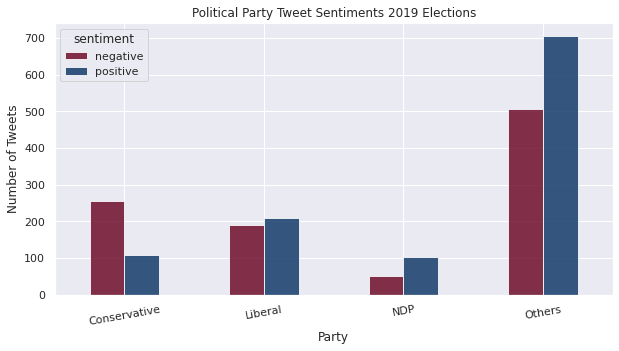

In [ ]:
#clean Tweet 
df_election['clean_text']=df_election['text'].apply(clean_tweet)

# Run our Party assignement function through the data set
df_election['Party'] = df_election['clean_text'].apply(party)
df_election.head(10)


df_election['Count'] = 1
df_election.head(10)



party_db = df_election[['Party','sentiment','Count']]
print(party_db.groupby('Party').describe())


pvt_party = party_db.pivot_table(values='Count',index='sentiment',columns='Party',aggfunc=np.sum)
pvt_party


pvt_party.transpose()


pvt_party.transpose().plot.bar(figsize=(10,5) , cmap='RdBu' , alpha = 0.8)
#label the figure
plt.title('Political Party Tweet Sentiments 2019 Elections')
plt.ylabel('Number of Tweets')
plt.savefig('Politiacal Sentiments 2015 Elections.png', dpi=100)

plt.xticks( rotation=10)


**Discussion** : As we can see, in the above plot we can see numbers of tweets based on their parties, most of the tweets do not belong to the main parties, for liberal party, high proportion of tweets are positvive, while for conservative, it is vice versa and the higher proportion of tweets are negative. Also, NDP has less number of tweets in comparison to the other two parties. 

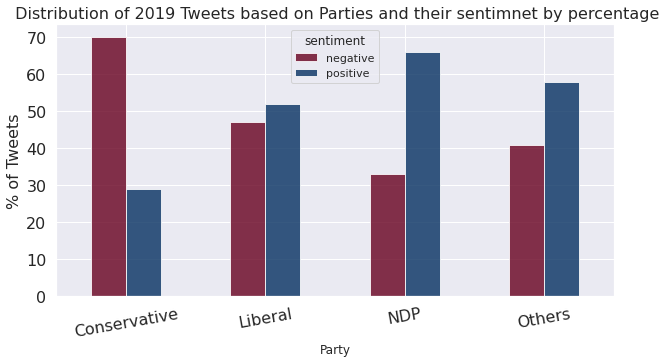

In [ ]:
# Plotting the percentage distribution of political affiliations of Canadian election 2019 tweets

pvt_party3 = pvt_party.transpose()

pvt_party3.sum(axis=1)
csum = pvt_party3.sum(axis=1).loc['Conservative']
lsum = pvt_party3.sum(axis=1).loc['Liberal']
nsum = pvt_party3.sum(axis=1).loc['NDP']
osum = pvt_party3.sum(axis=1).loc['Others']

pvt_partyp =pvt_party3.copy()
pvt_partyp

pvt_partyp.loc['Conservative']['negative'] = (pvt_party3.loc['Conservative']['negative']/csum)*100.0
pvt_partyp.loc['Conservative']['positive'] = (pvt_party3.loc['Conservative']['positive']/csum)*100.0
pvt_partyp.loc['Liberal']['negative'] = (pvt_party3.loc['Liberal']['negative']/lsum)*100.0
pvt_partyp.loc['Liberal']['positive'] = (pvt_party3.loc['Liberal']['positive']/lsum)*100.0
pvt_partyp.loc['NDP']['negative'] = (pvt_party3.loc['NDP']['negative']/nsum)*100.0
pvt_partyp.loc['NDP']['positive'] = (pvt_party3.loc['NDP']['positive']/nsum)*100.0
pvt_partyp.loc['Others']['negative'] = (pvt_party3.loc['Others']['negative']/osum)*100.0
pvt_partyp.loc['Others']['positive'] = (pvt_party3.loc['Others']['positive']/osum)*100.0

pvt_partyp.plot.bar(figsize=(10,5) , cmap='RdBu' , alpha = 0.8)
#label the figure
plt.title(' Distribution of 2019 Tweets based on Parties and their sentimnet by percentage' , fontsize=16)
plt.ylabel('% of Tweets' , fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks( rotation=10)
plt.savefig('Distribution of 2019 Tweets based on Parties and their sentimnet by percentage %.png', dpi=300)

**Discussion** : With showing sentiment of tweets for different parties based on their percentage, we can intutively find out the proportian of positive and negetive tweets for each of them more clearly. For instance, in this plot, it is totally clear that a high percentage of Conservative tweets are negetive.
The outcome of the election was Liberal Party in 2019. Acccording to our analysis, Liberal tweets wast found to be the most numerous with highest percentafe of positive sentiment, while the conservative that went second in the election had highest rate of negetive tweets. 
This shows that a sentiment analysis of political tweets can somehow predict the performance of each party in the election. The more comprehensive the data will be gathered, the higher chance of correct prediction of election result we will have. 

In [ ]:
#clean data for wordcloud
df_election['clean_text']=df_election['text'].apply(lambda x: text_cleaning(x))
df_election['clean_text'].head(5)

0    instead suggestion agree canadian woman trust andrewscheer conservative government protect woman right automony body let go cdnpoli elxn canada abortion         
1    allwomanspacewalk real netobicokenorth cityofto onpoli cdnpoli elxn                                                                                              
2    brantford going cost billion next year ask justin elxn cdnpoli canada                                                                                            
3    canada canadaelection canadavotes nelxn ncan decide help                                                                                                         
4    canada taxpayer sick tired hard earned donated corporate welfare bum need one many reason trudeaumustgo leave canada care snclavalinscandal election elxn cdnpoli
Name: clean_text, dtype: object

In [ ]:
from google.colab import files
df_election.to_csv('election_cleaned.csv' , index=False) 


In [ ]:
##I saved cleaned data in order not to run it every time
df_election=pd.read_csv('election_cleaned.csv')

##Word Cloud for Election dataset

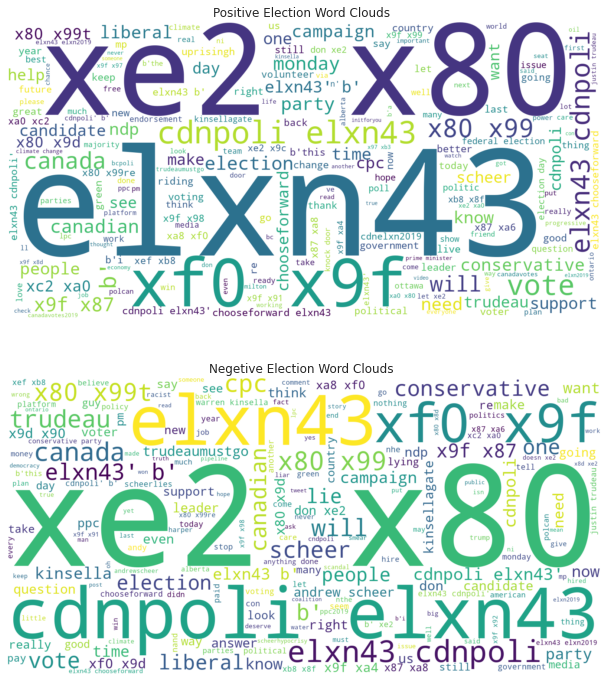

<Figure size 792x1152 with 0 Axes>

In [ ]:
#Word cloud - Election Tweets - Positive Tweets
election_tweets = df_election['clean_text'][df_election['sentiment']=='positive']
election_txt = []
for tweet in election_tweets:
   election_txt.append(tweet)
    
election_txt = pd.Series(election_txt).str.cat(sep=' ')


pos_wordcloud = WordCloud(width=1600, height=800,max_font_size=400, background_color ='white').generate(election_txt)

fig, ax = plt.subplots(2, 1, figsize = (16,12))
ax[0].set_title('Positive Election Word Clouds ')
ax[0].imshow(pos_wordcloud, interpolation="bilinear")
ax[0].axis("off")

plt.savefig('Positive Election Word Clouds.png' , dpi=30)


#Word cloud - Negetive Tweets
election_tweets = df_election['clean_text'][df_election['sentiment']=='negative']
election_txt = []
for tweet in election_tweets:
   election_txt.append(tweet)
    
election_txt = pd.Series(election_txt).str.cat(sep=' ')

neg_wordcloud = WordCloud(width=1600, height=800,max_font_size=400, background_color ='white').generate(election_txt)


ax[1].imshow(neg_wordcloud, interpolation="bilinear")
ax[1].axis("off")
ax[1].set_title('Negetive Election Word Clouds ')

plt.show()
plt.savefig('Negetive Election Word Clouds.png' ,  dpi=300)



**Discussion** : It is obvious that the hashtag "elxn43", which is "Canada's Election 43 (#ELXN43)", is the most frequent keyword. Other frequent words are also related to the general election things. It is also shown that the word "scheer" is one of the other important words, which is in negative tweets. Or for instance "**trudeaumustgo**" is one of key words in negetive tweets. "**chooseforward**" is one of the important keywords, which is related to the Liberal Party and it is repetetive in positive tweets. 

This word could also shows  most negetive public's opinion were toward major parties (Liberal and Conservatives) as we can see Trudeau and Sheer as major important words in negetive world cloud.


In [ ]:
#copy df_election to change sentiment to integers
df_election_cleaned = df_election.copy()
df_election_cleaned.head(3)

sentiment                      negative_reason  \
0  negative  Women Reproductive right and Racism   
1  positive  NaN                                   
2  negative  Economy                               

                                                                                                                                                                                                                                                                                            text  \
0  b"@RosieBarton So instead of your suggestion, how about we agree that #Canadian #women can not and should not trust that #AndrewScheer and a #Conservatives government will protect a woman's right to have automony over her body. Let's go with that.  #cdnpoli #elxn43  #Canada #abortion"   
1  b"#AllWomanSpacewalk it's real!\n@Space_Station \n#EtobicokeNorth #CityofTO #ONPoli #cdnpoli #elxn43 https://t.co/wgdXLksTbQ"                                                                                                                                                                   
2  b"#Brantford It's going to cost YOU $94 BILLION FOR THE NEXT 4 YEARS! ASK JUSTIN! #elxn43 #cdnpoli #Canada https://t.co/9DTLLd9972"                                                                                                                                                             

                                                                                                                                                                                                                                                                                clean_text  \
0  ['b" so instead of your suggestion, how about we agree that #canadian #women can not and should not trust that #andrewscheer and a #conservatives government will protect a woman\'s right to have automony over her body. let\'s go with that.  #cdnpoli #elxn43  #canada #abortion"']   
1  ['b"#allwomanspacewalk it\'s real!\\n \\n#etobicokenorth #cityofto #onpoli #cdnpoli #elxn43 ']                                                                                                                                                                                            
2  ['b"#brantford it\'s going to cost you $94 billion for the next 4 years! ask justin! #elxn43 #cdnpoli #canada ']                                                                                                                                                                          

          Party  Count  
0  Conservative  1      
1  Others        1      
2  Liberal       1

In [ ]:
#replace positive sentiment with 1 and negative with 0
df_election_cleaned['sentiment'].replace('positive' , 1 , inplace = True)
df_election_cleaned['sentiment'].replace('negative' , 0 , inplace = True)


In [ ]:
df_election_cleaned.head(5)

sentiment                      negative_reason  \
0  0          Women Reproductive right and Racism   
1  1          NaN                                   
2  0          Economy                               
3  1          NaN                                   
4  0          Economy                               

                                                                                                                                                                                                                                                                                                                    text  \
0  b"@RosieBarton So instead of your suggestion, how about we agree that #Canadian #women can not and should not trust that #AndrewScheer and a #Conservatives government will protect a woman's right to have automony over her body. Let's go with that.  #cdnpoli #elxn43  #Canada #abortion"                           
1  b"#AllWomanSpacewalk it's real!\n@Space_Station \n#EtobicokeNorth #CityofTO #ONPoli #cdnpoli #elxn43 https://t.co/wgdXLksTbQ"                                                                                                                                                                                           
2  b"#Brantford It's going to cost YOU $94 BILLION FOR THE NEXT 4 YEARS! ASK JUSTIN! #elxn43 #cdnpoli #Canada https://t.co/9DTLLd9972"                                                                                                                                                                                     
3  b"#Canada #CanadaElection2019 #CanadaVotes \n#elxn43 \n\nCan't decide? This should help!\n\nhttps://t.co/UNe5J1tDJ6"                                                                                                                                                                                                    
4  b"#Canada #taxpayers are sick &amp; tired of having their hard earned $ donated to corporate welfare bums that don't need it! This is only one of many reasons #TrudeauMustGo. @SNCLavalin can leave #Canada for all I care. @Sheila_Copps #SNCLavalinScandal #Election2019 #elxn43 #cdnpoli https://t.co/ywD7MAByKk"   

                                                                                                                                                                                                                                                                                clean_text  \
0  ['b" so instead of your suggestion, how about we agree that #canadian #women can not and should not trust that #andrewscheer and a #conservatives government will protect a woman\'s right to have automony over her body. let\'s go with that.  #cdnpoli #elxn43  #canada #abortion"']   
1  ['b"#allwomanspacewalk it\'s real!\\n \\n#etobicokenorth #cityofto #onpoli #cdnpoli #elxn43 ']                                                                                                                                                                                            
2  ['b"#brantford it\'s going to cost you $94 billion for the next 4 years! ask justin! #elxn43 #cdnpoli #canada ']                                                                                                                                                                          
3  ['b"#canada #canadaelection2019 #canadavotes \\n#elxn43 \\n\\ncan\'t decide? this should help!\\n\\n']                                                                                                                                                                                    
4  ['b"#canada #taxpayers are sick & tired of having their hard earned $ donated to corporate welfare bums that don\'t need it! this is only one of many reasons #trudeaumustgo.  can leave #canada for all i care.  #snclavalinscandal #election2019 #elxn43 #cdnpoli ']                    

          Party  Count  
0  Conservative  1      
1  Others        1  

##Implementation of the best model on canadian election dataset

As logistic regression gave us best result on generic tweet, we will use it for election tweet and calculte the accuracy

In [ ]:
#Building X and y based on cleaned data
X = df_election_cleaned['clean_text']
y = df_election_cleaned['sentiment']


In [ ]:
#sparse matrix for TF-IDF
TF_IDF_train = TF_IDF_vectorizer.fit(X_train)
X_TF_IDF = TF_IDF_vectorizer.transform(X)


In [ ]:
#logistic Regression

import joblib
filename = 'model_LR_TF_IDF.sav'
loaded_model = joblib.load('model_LR_TF_IDF.sav')
predictions = loaded_model.predict(X_TF_IDF) 
accuracy = accuracy_score(y, predictions)
f1_test_score = f1_score(y , predictions , average='macro')

print ("This model got an accuracy of {}% on the testing set".format(round(accuracy*100,3))) 
print ("This model got a f1_score of {}% on the testing set".format(round(f1_test_score*100,3)))


This model got an accuracy of 95.342% on the testing set
This model got a f1_score of 94.711% on the testing set


**Discussion** : The best model got score of 59.45% on the election dataset, although the result is not that much well, but as the model is new to this dataset, and we don't do any hyperparameter tunning on it,  so the model is alomost working good on Election dataset. The performance can be improved by hyperpaarameter tunning

#Visualising Prediction Results for different Parties
In this part, we will seperate tweets based on parties and perform prediction on them specifically, then we compare the prediction with actual tweets sentiment

In [ ]:
#visualise predicted sentiment for each party
liberal_X = df_election_cleaned['clean_text'][ df_election_cleaned['Party'] == 'Liberal']
liberal_sent = df_election_cleaned['sentiment'][ df_election_cleaned['Party'] == 'Liberal']
Liberal_TFIDF = TF_IDF_vectorizer.transform(liberal_X)
filename = 'model_LR_TF_IDF.sav'
loaded_model = joblib.load('model_LR_TF_IDF.sav')
Liberal_predictions = loaded_model.predict(Liberal_TFIDF)
Liberals_df = pd.DataFrame(Liberal_predictions , columns = ['prediction'])
Liberals_df ['actual'] = liberal_sent.reset_index(drop=True)


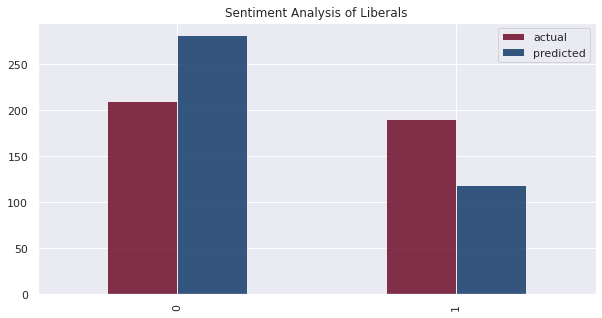

In [ ]:
actual = Liberals_df['actual'].value_counts().reset_index(drop=True)
pred = Liberals_df['prediction'].value_counts().reset_index(drop=True)
df_liberal = pd.DataFrame({'actual': actual, 'predicted': pred}, index=pred.index)
ax = df_liberal.plot.bar(figsize=(10,5) , cmap='RdBu' , alpha = 0.8)
plt.title('Sentiment Analysis of Liberals')
plt.show()


**Discussion**: For Liberal party, the model does not perform well but not too bad, it predicts tweets with negtive sentiment more than its real number and for positive less

In [ ]:
#visualise predicted sentiment for each party
ndp_X = df_election_cleaned['clean_text'][ df_election_cleaned['Party'] == 'NDP']
ndp_sent = df_election_cleaned['sentiment'][ df_election_cleaned['Party'] == 'NDP']
ndp_TFIDF = TF_IDF_vectorizer.transform(ndp_X)
filename = 'model_LR_TF_IDF.sav'
loaded_model = joblib.load('model_LR_TF_IDF.sav')
ndp_predictions = loaded_model.predict(ndp_TFIDF)
ndps_df = pd.DataFrame(ndp_predictions , columns = ['prediction'])
ndps_df ['actual'] = ndp_sent.reset_index(drop=True)


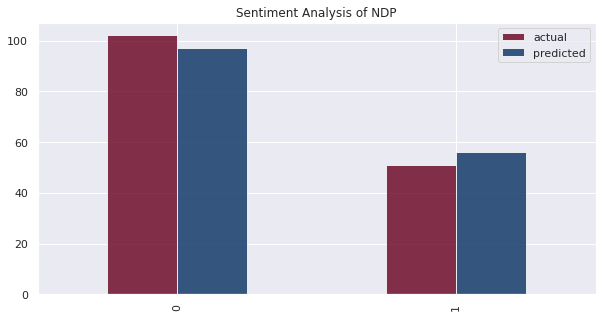

In [ ]:
actual=ndps_df['actual'].value_counts().reset_index(drop=True)
pred=ndps_df['prediction'].value_counts().reset_index(drop=True)
df_ndp = pd.DataFrame({'actual': actual, 'predicted': pred}, index=pred.index)
ax = df_ndp.plot.bar(figsize=(10,5) , cmap='RdBu' , alpha = 0.8)
plt.title('Sentiment Analysis of NDP')
plt.show()

**Discussion**: For NDP party, the model gives opposite results in comparison to Liberal, it predicts tweets with negtive sentiment less than its real number and for positive higher than what it was

In [ ]:
#visualise predicted sentiment for each party
cons_X = df_election_cleaned['clean_text'][ df_election_cleaned['Party'] == 'Conservative']
cons_sent = df_election_cleaned['sentiment'][ df_election_cleaned['Party'] == 'Conservative']
cons_TFIDF = TF_IDF_vectorizer.transform(cons_X)
filename = 'model_LR_TF_IDF.sav'
loaded_model = joblib.load('model_LR_TF_IDF.sav')
cons_predictions = loaded_model.predict(cons_TFIDF)
conss_df = pd.DataFrame(cons_predictions , columns = ['prediction'])
conss_df ['actual'] = cons_sent.reset_index(drop=True)

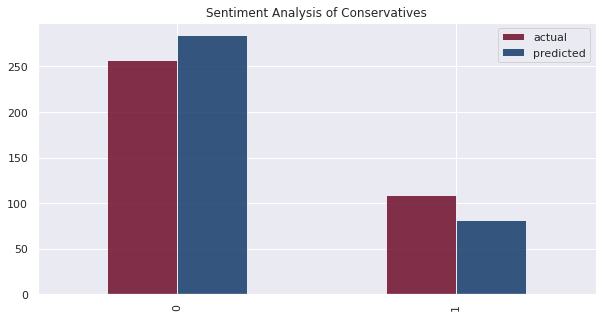

In [ ]:
actual=conss_df['actual'].value_counts().reset_index(drop=True)
pred=conss_df['prediction'].value_counts().reset_index(drop=True)
df_cons = pd.DataFrame({'actual': actual, 'predicted': pred}, index=pred.index)
ax = df_cons.plot.bar(figsize=(10,5) , cmap='RdBu' , alpha = 0.8)
plt.title('Sentiment Analysis of Conservatives')
plt.show()


**Discussion**: For Conservative party, the model works like the Liberal party, it predicts tweets with negtive sentiment more than its real number and for positive less than it was

# Results and Discussion- Part1

## Answering the research question based on the first model 
Let's focus on the positive counts of each party first! So, as we can see, liberals contain the most, followed by conservatives and NDPs. The results of the election actually match with this sequence, which means how the liberals came first, and the conservatives and NDP after. 

While NDP has high number of positive tweets but the number of tweets for this party is limited, so we understand that number can also play an important factor in winning the election as the number of NDP voters were much less.

 What we conclude here is that the results of the sentiment analysis of this assignment based on the first modelling are in line with the results of the Canada elections. 
 


##How is each party viewed in the public eye based on the sentiment value?

Also, we can see in the plot, liberals have achieved the most count of positive sentiments in comparison with other parties, they have also obtained more positive sentiments in comparison with the number of negative sentiments. On the other hand, conservatives contain the most negative sentiments versus other parties, and the number of their negative sentiments is also more than their positive ones. The NDPs, as discussed before, can be interpreted as the minorities of the parties, with this difference that the NDPs contain more positive tweets than negative ones. So now it is crystal clear that liberals are more famous in the public eye rather than the conservatives.

##How NLP analytics based on tweets is useful for political parties during election campaigns ?

 

*   NLP can help of analyze how each party has been influenced on people's
*   opinition by analyzing sentement of the tweet. It give us a good reflection of public views on each parties and it can be considered as the voice of general public
*   Each parties can benefit a social media team to make meaningful reactions to general people view and tweets, and change the result to thier benefits with creatign relevent content and hashtags that are capable of getting viral and directing public's doubts or offenses


#3.Exploring the reasons for Negative election tweets

In [ ]:
reason_count=df_election_cleaned['negative_reason'].value_counts()
reason_count

Others                                 365
Scandal                                270
Tell lies                              198
Economy                                51 
Women Reproductive right and Racism    45 
Climate Problem                        41 
Separation                             16 
Privilege                              12 
Healthcare                             5  
Healthcare and Marijuana               4  
Name: negative_reason, dtype: int64

In [ ]:
#plot negative reasons
import plotly.express as px
import plotly.offline as pyo
# Set notebook mode to work in offline
pyo.init_notebook_mode()
fig = px.pie(df_election_cleaned, values=reason_count.values, names=reason_count.index)
fig.update_layout(title_x=0.48,legend={"x" : 0.7, "y" : 1})
fig.show(renderer="colab")

Here, we decide to categorice the last 4 reasons as others, since the number of times they been counted in the dataset is less than 20.

In [ ]:
df_election_cleaned['negative_reason'].replace({'Healthcare and Marijuana':'Others',\
                                              'Healthcare':'Others',\
                                              'Privilege':'Others','Separation':'Others'},inplace=True)
df_election_cleaned[df_election_cleaned['sentiment']==0].head()

sentiment                      negative_reason  \
0  0          Women Reproductive right and Racism   
2  0          Economy                               
4  0          Economy                               
5  0          Others                                
8  0          Others                                

                                                                                                                                                                                                                                                                                                                    text  \
0  b"@RosieBarton So instead of your suggestion, how about we agree that #Canadian #women can not and should not trust that #AndrewScheer and a #Conservatives government will protect a woman's right to have automony over her body. Let's go with that.  #cdnpoli #elxn43  #Canada #abortion"                           
2  b"#Brantford It's going to cost YOU $94 BILLION FOR THE NEXT 4 YEARS! ASK JUSTIN! #elxn43 #cdnpoli #Canada https://t.co/9DTLLd9972"                                                                                                                                                                                     
4  b"#Canada #taxpayers are sick &amp; tired of having their hard earned $ donated to corporate welfare bums that don't need it! This is only one of many reasons #TrudeauMustGo. @SNCLavalin can leave #Canada for all I care. @Sheila_Copps #SNCLavalinScandal #Election2019 #elxn43 #cdnpoli https://t.co/ywD7MAByKk"   
5  b"#CanadaVotes2019 #elxn43 #cdnpoli - FACTS - #BlastFromThePast - In 2012 #Conservatives introduced the end of the long-gun registry even though all heads of police across Canada and victims' groups objected for crime control and public safety! #GunLobby  https://t.co/WgZKMSQ4wa"                                
8  b"#chooseforward #cdnpoli #elxn43\nCanada, Don't Make America's Mistakes | Full Frontal on TBS https://t.co/PhU4jHxnMF via @YouTube"                                                                                                                                                                                    

                                                                                                                                                                                                                                                                                clean_text  \
0  ['b" so instead of your suggestion, how about we agree that #canadian #women can not and should not trust that #andrewscheer and a #conservatives government will protect a woman\'s right to have automony over her body. let\'s go with that.  #cdnpoli #elxn43  #canada #abortion"']   
2  ['b"#brantford it\'s going to cost you $94 billion for the next 4 years! ask justin! #elxn43 #cdnpoli #canada ']                                                                                                                                                                          
4  ['b"#canada #taxpayers are sick & tired of having their hard earned $ donated to corporate welfare bums that don\'t need it! this is only one of many reasons #trudeaumustgo.  can leave #canada for all i care.  #snclavalinscandal #election2019 #elxn43 #cdnpoli ']                    
5  ['b"#canadavotes2019 #elxn43 #cdnpoli - facts - #blastfromthepast - in 2012 #conservatives introduced the end of the long-gun registry even though all heads of police across canada and victims\' groups objected for crime control and public safety! #gunlobby  ']                     
8  ['b"#chooseforward #cdnpoli #elxn43\\ncanada, don\'t make america\'s mistakes | full frontal on tbs  via ']                                                                                                                                                                               

          Party  Count  
0  Conservative  1      
2  Liberal       1  

In [ ]:
df_election_cleaned['negative_reason'].value_counts()

Others                                 402
Scandal                                270
Tell lies                              198
Economy                                51 
Women Reproductive right and Racism    45 
Climate Problem                        41 
Name: negative_reason, dtype: int64

Since we need to implement a multi-class classification, we need to substitute each category of negative reason with an assigned number.

In [ ]:
df_election_cleaned['negative_reason'].replace({'Others':1,\
                                              'Scandal':2,\
                                              'Tell lies':3,'Economy':4, 'Women Reproductive right and Racism':5, \
                                                      'Climate Problem':6},inplace=True)
df_elec_neg=df_election_cleaned[df_election_cleaned['sentiment']==0]

In [ ]:
X_elec_train, X_elec_test, y_elec_train, y_elec_test = train_test_split(df_elec_neg['clean_text'], df_elec_neg['negative_reason'], random_state=31, test_size=0.3)


##3.1 Predicting the reasons for negative election tweets 
We will implement the classification using TF-IDF features and three classification modellings

In [ ]:
elec_TFIDF_vectorizer = TfidfVectorizer(max_features = 2000 )
elec_TFIDF_train = elec_TFIDF_vectorizer.fit_transform(X_elec_train)
elec_TFIDF_test = elec_TFIDF_vectorizer.transform(X_elec_test)



In [ ]:
#model  LogisticRegression - TFIDF
model_LR_TFIDF_elec = LogisticRegression( C=10 , solver = 'saga' , random_state=0)    
model_LR_TFIDF_elec.fit(elec_TFIDF_train, y_elec_train)
train_predictions_elec = model_LR_TFIDF_elec.predict(elec_TFIDF_train)
predictions_elec = model_LR_TFIDF_elec.predict(elec_TFIDF_test)


f1_train_score = f1_score(y_elec_train, train_predictions_elec ,  average='micro')   
accuracy = accuracy_score(y_elec_test, predictions_elec)
precision = precision_score(y_elec_test, predictions_elec , average='micro')
recall = recall_score(y_elec_test, predictions_elec ,  average='micro')
f1_test_score = f1_score(y_elec_test, predictions_elec,  average='micro')



print ("This model got an accuracy of {}% on the testing set".format(round(accuracy*100,3))) 
print ("This model got a precision of {}% on the testing set".format(round(precision*100,3))) 
print ("This model got a recall of {}% on the testing set".format(round(recall*100,3)))
print ("This model got a f1_score of {}% on the testing set".format(round(f1_test_score*100,3)))
print ("\nThis model got a f1_score of {}% on the training set".format(round(f1_train_score*100,3)))

This model got an accuracy of 53.311% on the testing set
This model got a precision of 53.311% on the testing set
This model got a recall of 53.311% on the testing set
This model got a f1_score of 53.311% on the testing set

This model got a f1_score of 100.0% on the training set


In [ ]:
#Random Forest

model_RF_TFIDF_elec=RandomForestClassifier(random_state=42)

model_LR_TFIDF_elec.fit(elec_TFIDF_train, y_elec_train)
train_predictions_elec = model_LR_TFIDF_elec.predict(elec_TFIDF_train)
predictions_elec = model_LR_TFIDF_elec.predict(elec_BagofWords_test)


f1_train_score = f1_score(y_elec_train, train_predictions_elec ,  average='micro')   
accuracy = accuracy_score(y_elec_test, predictions_elec)
precision = precision_score(y_elec_test, predictions_elec , average='micro')
recall = recall_score(y_elec_test, predictions_elec ,  average='micro')
f1_test_score = f1_score(y_elec_test, predictions_elec,  average='micro')



print ("This model got an accuracy of {}% on the testing set".format(round(accuracy*100,3))) 
print ("This model got a precision of {}% on the testing set".format(round(precision*100,3))) 
print ("This model got a recall of {}% on the testing set".format(round(recall*100,3)))
print ("This model got a f1_score of {}% on the testing set".format(round(f1_test_score*100,3)))
print ("\nThis model got a f1_score of {}% on the training set".format(round(f1_train_score*100,3)))

This model got an accuracy of 50.993% on the testing set
This model got a precision of 50.993% on the testing set
This model got a recall of 50.993% on the testing set
This model got a f1_score of 50.993% on the testing set

This model got a f1_score of 100.0% on the training set


In [ ]:
#SVM
model_SVM_TF_IDF = SGDClassifier(max_iter=1000, tol=1e-3)
model_SVM_TF_IDF.fit(elec_TFIDF_train, y_elec_train)

predictions_elec = model_SVM_TF_IDF.predict(elec_TFIDF_test)
    
train_predictions = model_SVM_TF_IDF.predict(elec_TFIDF_train)
    

f1_train_score = f1_score(y_elec_train, train_predictions_elec ,  average='micro')   
accuracy = accuracy_score(y_elec_test, predictions_elec)
precision = precision_score(y_elec_test, predictions_elec , average='micro')
recall = recall_score(y_elec_test, predictions_elec ,  average='micro')
f1_test_score = f1_score(y_elec_test, predictions_elec,  average='micro')

print ("This model got an accuracy of {}% on the testing set".format(round(accuracy*100,3))) 
print ("This model got a precision of {}% on the testing set".format(round(precision*100,3))) 
print ("This model got a recall of {}% on the testing set".format(round(recall*100,3)))
print ("This model got a f1_score of {}% on the testing set".format(round(f1_test_score*100,3)))
print ("\nThis model got a f1_score of {}% on the training set".format(round(f1_train_score*100,3)))


This model got an accuracy of 55.298% on the testing set
This model got a precision of 55.298% on the testing set
This model got a recall of 55.298% on the testing set
This model got a f1_score of 55.298% on the testing set

This model got a f1_score of 100.0% on the training set


**Discussion**: The best models for predicting negative reasons is SVM which gives us 55.298 acuracy on the dataset, we will discuss why models does not perform well in later part

##3.2 Hypertunning Parameters

### Hypertune Logistic Regression
In this part we will tune the model based on the hyperparameters to calculate best accuracy. 

We use Gridsearch, It define a search space as a grid of hyperparameter values and evaluate every position in the grid.


we can see useful differences in performance or convergence with different solvers (solver).
solver in [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’]
Regularization (penalty) can sometimes be helpful.
penalty in [‘none’, ‘l1’, ‘l2’]
Note: not all solvers support all regularization terms.
The C parameter controls the penality strength, which can also be effective.
C in [0.001, 0.01, 0.1, 1, 10, ]

In [ ]:
from sklearn.model_selection import GridSearchCV


# The hyperparameters for Logistic Regression
parameters = {'C':[0.001, 0.01, 0.1, 1, 10, ], 'penalty' :['l1', 'l2'],
              'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# Tuning implementation
tuned_model_LR_TFIDF_elec = GridSearchCV(model_LR_TFIDF_elec, parameters, cv=10)
tuned_model_LR_TFIDF_elec.fit(elec_BagofWords_train , y_elec_train)
print('The best parameters are: ', tuned_model_LR_TFIDF_elec.best_params_)
score_LR_TFIDF=tuned_model_LR_TFIDF_elec.best_score_
print('The accuracy of the tuned model is', score_LR_TFIDF*100,'%')

The best parameters are:  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
The accuracy of the tuned model is 55.68812877263583 %


#Hyperparameter tunning for Random Forest
Random forest is a develped decision tree algorithm. It generates multiple small decision trees from random subsets of the data. Each of the decision tree gives a biased classifier. They each capture different trends in the data. This ensemble of trees is like a team of experts each with a little knowledge over the overall subject but thourough in their area of expertise. 

**max_features:**

These are the maximum number of features Random Forest is allowed to try in individual tree. 
Auto/None : This will simply take all the features which make sense in every tree.Here we simply do not put any restrictions on the individual tree.
sqrt : This option will take square root of the total number of features in individual run. For instance, if the total number of variables are 100, we can only take 10 of them in individual tree.”log2″ is another similar type of option for max_features.
log.2 : This option allows the random forest to take 20% of variables in individual run. We can assign and value in a format “0.x” where we want x% of features to be considered.

**max_depth:**
 represents the depth of each tree in the forest. The deeper the tree, the more splits it has and it captures more information about the data.

**criterion**

measures the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific.

In [ ]:
#tunning Hyperparameters for Random Forest
model_RF_TFIDF_elec = RandomForestClassifier(random_state=42)
param_grid = { 'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth' : [60 , 70, 80, 90, 100], 'criterion' :['gini', 'entropy']
}
tuned_model_RF_TFIDF_elec = GridSearchCV(estimator=model_RF_TFIDF_elec, param_grid=param_grid, cv= 5)
tuned_model_RF_TFIDF_elec.fit(elec_TFIDF_train, y_elec_train)
print('The best parameters are: ', tuned_model_RF_TFIDF_elec.best_params_)
score_RF_TFIDF=tuned_model_RF_TFIDF_elec.best_score_
print('The accuracy of the tuned model is', score_RF_TFIDF*100,'%')




The best parameters are:  {'criterion': 'gini', 'max_depth': 60, 'max_features': 'auto', 'n_estimators': 500}
The accuracy of the tuned model is 55.68490374873354 %


#Hyperparameter tunning for SGD Classifer

SGD Classifier implements regularised linear models with Stochastic Gradient Descent.

**penalty**{‘l2’, ‘l1’, ‘elasticnet’}
represent the penalty (aka regularization term) to used
loss

**alpha**
Constant that multiplies the regularization term. The higher the value, the stronger the regularization. Also used to compute the learning rate when set to learning_rate is set to ‘optimal’.


**loss**
The loss function to be used

In [ ]:
#tunning Hyperparameters for SVM

model_SVM_TFIDF_elec = SGDClassifier(random_state=42)
param_grid = { 
    'penalty' : ['l1', 'l2', 'elasticnet'], 'loss' : ['squared_loss', 'huber', 'epsilon_insensitive'], 'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
}
tuned_model_SVM_TFIDF_elec = GridSearchCV(estimator=model_SVM_TFIDF_elec, param_grid=param_grid, cv= 5)
tuned_model_SVM_TFIDF_elec.fit(elec_TFIDF_train, y_elec_train)
print('The best parameters are: ', tuned_model_SVM_TFIDF_elec.best_params_)
score_SVM_TFIDF=tuned_model_SVM_TFIDF_elec.best_score_
print('The accuracy of the tuned model is', score_SVM_TFIDF*100,'%')





The best parameters are:  {'alpha': 0.001, 'loss': 'squared_loss', 'penalty': 'l1'}
The accuracy of the tuned model is 57.53191489361702 %


**Discussion**: It seems that SVM gives us the best accuracy for predicting the negative reason which is 57.5%

#4.Result - Part 4
Based on the best model, provide a few reasons why the model failed, back up with some examples from the test set.To find the reason for poor performance of the model, we first generate a predictions dataframe that illustrates the actual reason and the prediction. Afterward, we show ten examples where the model failed to predict the right reason. 

In [ ]:
#Checking incorect predicted tweets 
model_SVM_TF_IDF = SGDClassifier( max_iter=1000, tol=1e-3,alpha = 0.001, loss='squared_loss', penalty ='l1')
model_SVM_TF_IDF.fit(elec_TFIDF_train, y_elec_train)
predictions_elec = model_SVM_TF_IDF.predict(elec_TFIDF_test)



In [ ]:
predictiondf=pd.DataFrame()
counter=0
for i in X_elec_test.index:
    predictiondf.loc[i,'clean_text'] = X_elec_test[i]
    predictiondf.loc[i,'reason'] = df_election_cleaned['negative_reason'][i]
    predictiondf.loc[i,'prediction'] = predictions_elec[counter]
    counter+=1
predictiondf.head()

clean_text  \
819   ['b\'     "may or may not"\\ntoo funny!  is channeling rob ford\\\'s "a video that may or may not exist". guess what andy? it existed and we all know you meant "yes". yes you did hire the self-serving-rapidly-sinking-into-irrelevance warren. #elxn43 #elxn2019 #cdnpoli\'']   
1673  ['b\'nothing quite like "right on right" crime.   #cpc #ppc #elxn43\'']                                                                                                                                                                                                            
1718  ["b'people vying to head #canada are so afraid of #quebec extremists like blanchet and his political boss legault that they never make the argument for federalism and for canada. how do any of them deserve to be pm of our country? #cdnpoli #canpoli #elxn43 #elxn2019'"]      
2013  ['b\'want to play a game called "may or may not"? \\n\\ni may or may not be a gay alien from outer space. \\xf0\\x9f\\x8f\\xb3\\xef\\xb8\\x8f\\xe2\\x80\\x8d\\xf0\\x9f\\x8c\\x88\\xf0\\x9f\\x91\\xbd\\n#elxn43 #mayormaynot #scheerdisaster ']                                     
158   ['b"  they\'re so open about it because there are so many racists in canada that having him as campaign manager is a selling point. #tragic #cdnpoli #elxn43 #scheerdisaster"']                                                                                                    

      reason  prediction  
819   1.0     1.0         
1673  1.0     2.0         
1718  1.0     1.0         
2013  1.0     1.0         
158   5.0     1.0

In [ ]:
counter=0
a=[]
for i in predictiondf.index:
    if counter<10:
        if predictiondf['reason'][i]!=predictiondf['prediction'][i]:
            print(predictiondf['clean_text'][i],predictiondf['reason'][i],predictiondf['prediction'][i],'\n')
            counter+=1

['b\'nothing quite like "right on right" crime.   #cpc #ppc #elxn43\''] 1.0 2.0 

['b"  they\'re so open about it because there are so many racists in canada that having him as campaign manager is a selling point. #tragic #cdnpoli #elxn43 #scheerdisaster"'] 5.0 1.0 

["b' yes. their campaign was attacking individuals on social media not affiliated with any party as racist whenever china and money laundering was brought up and tried to insinuate security concerns as hate speech #cdnpoli #elxn43 "] 5.0 2.0 

["b'i agree 100%\\nkinsellout is one creep.\\nthe cpc truly sold us all out.\\nthe cpc is erasing democracy.\\n#cdnpoli #elxn43 #nocpc \\n#abc #countryoverparty "] 2.0 1.0 

['b\'when thinking about kinsella and the toronto sun, keep this in mind...\\n\\nthe majority owner of postmedia is a foreign hedge fund run by a guy described as a "vulture"\\n\\n#elxn43 '] 2.0 1.0 

["b'that damn left wing media in canada #elxn43 #cdnpoli "] 2.0 1.0 

["b'thread..\\n\\nsince 2003, there have be

##4.1 Reasons of Model Failiure:
* First of all, in these ten examples we observe that we have the actual reason of 'scandal'(2) while being predicted as ' tell lies'(3). It is safe to say that while scandal and lies are different, they are very close to eachother in description. So, the model using TF-IDF features has the potential to predict the scandal label as tell lies by mistake.
* Second of all, we observe than amongst these ten examples, 6 of them either have the actual reason of 'others' or are predicted as 'others' by mistake. While 'others' category contained the very wide range from healthcare, previlage, separation to man other reasons not specifically stated in the dataset provided file, the potential of this category being predicted as one of the other categories such as 'scandal' or other categories being predicted as 'others' by mistake is very much.
* Third of all, cleaning stages of the election data may have contributed to this end

#4.2.Suggestion to Improve Accuaracy

* Having more number of tweets for each category, can improve model accuracy. 
Now, in both models, large amount of data belongs to other category, that does not give us enough meaningful information to train the models.

* By tunning hyperparameters (That we did in the last part) we can improve the models. 

* We can test of not removing stopwords to see if it can improve model accuracy. Reducing the data set size is without any doubt a way of increasing performance but, word importance may vary depending on the dataset. Problems like sentiment analysis are much more sensitive to stop words removal than document classification.
* Also we combined four of least repeated reasons into the others category. If we try keeping all the reasons, we may endup with a more accurate model. Finally, we can try other approaches for feature extraction, for inastance, word embedding and ngrams.